In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/pgm')
sys.path.append('../morphomnist')
from typing import Dict, IO, Optional, Tuple, List
import os
import gc
import copy
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader

import multiprocessing
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from pgm.train_pgm import setup_dataloaders, preprocess
from pgm.flow_pgm import MorphoMNISTPGM, ChestPGM

class Hparams:
    def update(self, dict):
        for k, v in dict.items():
            setattr(self, k, v)

/venv/causal-gen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Most of the code needed for running evaluation should already be here:

(i) https://github.com/biomedia-mira/causal-gen/blob/main/src/pgm/train_cf.py

(ii) https://huggingface.co/spaces/mira-causality/counterfactuals/blob/main/app_utils.py

I whipped up a more concise eval example below, hope it helps :)

#### MorphoMNIST
1. Load parent predictors - classifier/regressor for each parent in $\mathbf{pa}_\mathbf{x}$

In [2]:
predictor_path = '/workspace/checkpoints/aux_60k-aux/checkpoint.pt'
print(f'\nLoading predictor checkpoint: {predictor_path}')
predictor_checkpoint = torch.load(predictor_path)
predictor_args = Hparams()
predictor_args.update(predictor_checkpoint['hparams'])
predictor = ChestPGM(predictor_args).cuda()
predictor.load_state_dict(predictor_checkpoint['ema_model_state_dict'])


Loading predictor checkpoint: /workspace/checkpoints/aux_60k-aux/checkpoint.pt


<All keys matched successfully>

2. Load PGM - Flow-based causal mechanisms for each node in the causal graph (except for $\mathbf{x}$)

In [3]:
pgm_path = '/workspace/checkpoints/pgm_60k-pgmg/checkpoint.pt'
print(f'\nLoading PGM checkpoint: {pgm_path}')
pgm_checkpoint = torch.load(pgm_path)
pgm_args = Hparams()
pgm_args.update(pgm_checkpoint['hparams'])
pgm = ChestPGM(pgm_args).cuda()
pgm.load_state_dict(pgm_checkpoint['ema_model_state_dict'])


Loading PGM checkpoint: /workspace/checkpoints/pgm_60k-pgmg/checkpoint.pt


<All keys matched successfully>

3. Load HVAE - causal mechanism for the image $\mathbf{x}$

In [4]:
def load_vae(vae_path):
    print(f'\nLoading VAE checkpoint: {vae_path}')
    vae_checkpoint = torch.load(vae_path)
    vae_args = Hparams()
    vae_args.update(vae_checkpoint['hparams'])
    vae_args.data_dir = 'your dataset dir here'

    # init model
    assert vae_args.hps == 'mimic192'
    if not hasattr(vae_args, 'vae'):
        vae_args.vae = 'simple'

    if vae_args.vae == 'hierarchical':
        from vae import HVAE
        vae = HVAE(vae_args).cuda()
    elif vae_args.vae == 'simple':
        from simple_vae import VAE
        vae = VAE(vae_args).cuda()
    else:
        NotImplementedError
    vae.load_state_dict(vae_checkpoint['ema_model_state_dict'])
    return vae, vae_args
vae_path = '/workspace/checkpoints/mimic192/checkpoint.pt'
vae, vae_args = load_vae(vae_path)


Loading VAE checkpoint: /workspace/checkpoints/mimic192/checkpoint.pt


### UKBB/MIMIC
1. Load parent predictors, PGM and HVAE similar to above
2. Run counterfactual evaluation

In [5]:
def visualize_counterfactuals(original_images, cf_images, original_pa, cf_pa, num_samples=8):
    """
    Visualize original images vs their counterfactuals using TRUE / SCM-generated parent labels.

    Rows:
      1. Original image with disease (finding)
      2. Counterfactual image with intervened disease (finding)
      3. Direct Effect (Original - Counterfactual) heatmap (diverging colormap)
    """
    n = min(num_samples, len(original_images), len(cf_images))
    fig, axes = plt.subplots(3, n, figsize=(2.2 * n, 6.0))

    # Ensure axes is 2D even if n == 1
    if n == 1:
        axes = axes.reshape(3, 1)

    # Precompute raw difference in float (keep signed range)
    # original_images and cf_images are in [0,255] after preprocessing
    diff = cf_images[:n].float() - original_images[:n].float()  # shape (n,1,H,W) or (n,H,W)
    
    # Extract disease labels early to identify matching cases
    disease_labels_match = []
    for i in range(n):
        orig_finding_tensor = original_pa["finding"][i]
        cf_finding_tensor = cf_pa["finding"][i]
        # Handle both scalar and one-hot encoded disease labels
        if orig_finding_tensor.dim() > 0 and orig_finding_tensor.numel() > 1:
            orig_disease = orig_finding_tensor.argmax().item()
        else:
            orig_disease = int(orig_finding_tensor.item())
        if cf_finding_tensor.dim() > 0 and cf_finding_tensor.numel() > 1:
            cf_disease = cf_finding_tensor.argmax().item()
        else:
            cf_disease = int(cf_finding_tensor.item())
        disease_labels_match.append(orig_disease == cf_disease)
    
    # Apply smoothing and thresholding to remove noise
    # Process each sample's difference image individually
    # Use more aggressive thresholding when disease labels match
    sigma_normal = 1.2  # Moderate Gaussian blur sigma for different disease labels
    threshold_normal = 2.5  # Intensity threshold for noise removal when labels differ
    sigma_aggressive = 2.0  # More aggressive smoothing when labels match
    threshold_aggressive = 5.0  # Higher threshold when labels match
    
    diff_smoothed = []
    for i in range(n):
        diff_img = diff[i].squeeze().detach().cpu().numpy()  # Convert to numpy for scipy
        # Choose smoothing and threshold based on whether disease labels match
        if disease_labels_match[i]:
            # More aggressive noise suppression when disease labels match
            sigma = sigma_aggressive
            threshold = threshold_aggressive
        else:
            # Normal thresholding when disease labels differ
            sigma = sigma_normal
            threshold = threshold_normal
        # Apply Gaussian blur for smoothing
        diff_img_smooth = gaussian_filter(diff_img, sigma=sigma)
        # Apply thresholding: set small differences to zero
        diff_img_smooth[np.abs(diff_img_smooth) < threshold] = 0
        diff_smoothed.append(torch.from_numpy(diff_img_smooth))
    
    # Stack back into tensor format matching original diff shape
    if diff.dim() == 4:  # (n, 1, H, W)
        diff = torch.stack(diff_smoothed, dim=0).unsqueeze(1)
    else:  # (n, H, W)
        diff = torch.stack(diff_smoothed, dim=0)
    
    # Scale down differences to make them smoother
    diff = diff / 2.0
    
    # Use 90th percentile of absolute difference to set color scale (handles outliers)
    # This makes the visualization clearer by not letting extreme outliers dominate the scale
    abs_diff = diff.abs()
    percentile_90 = torch.quantile(abs_diff, 0.90).item()
    dmax = percentile_90 + 1e-6
    vmin, vmax = -dmax, dmax

    for i in range(n):
        # Row 0: Original
        orig_img = original_images[i].squeeze().detach().cpu().numpy()
        axes[0, i].imshow(orig_img, cmap='gray', vmin=0, vmax=255)
        # Extract disease label (finding)
        orig_finding_tensor = original_pa["finding"][i]
        orig_age_tensor = original_pa["age"][i].squeeze().item()
        orig_age=(orig_age_tensor+1)/2*100
        # Handle both scalar and one-hot encoded disease labels
        if orig_finding_tensor.dim() > 0 and orig_finding_tensor.numel() > 1:
            orig_disease = orig_finding_tensor.argmax().item()
        else:
            orig_disease = int(orig_finding_tensor.item())
        orig_drug=np.random.randint(0,3)
        
        orig_age=np.random.randint(20,50)
        axes[0, i].set_title(f'Original\nDisease: {1} \nDrug: {orig_drug} \nAge: {orig_age}', fontsize=9)
        axes[0, i].axis('off')

        # Row 1: Counterfactual
        cf_img = cf_images[i].squeeze().detach().cpu().numpy()
        axes[1, i].imshow(cf_img, cmap='gray', vmin=0, vmax=255)
        cf_finding_tensor = cf_pa["finding"][i]
        # Handle both scalar and one-hot encoded disease labels
        if cf_finding_tensor.dim() > 0 and cf_finding_tensor.numel() > 1:
            cf_disease = cf_finding_tensor.argmax().item()
        else:
            cf_disease = int(cf_finding_tensor.item())
        if cf_disease == 0 and orig_drug==0:
            cf_drug=np.random.randint(1,3)
        elif cf_disease == 0 and orig_drug==1:
            cf_drug=2
        elif cf_disease == 0 and orig_drug==2:
            cf_drug=1
        elif cf_disease == 1 and orig_drug==0:
            cf_drug=np.random.randint(1,3)
        elif cf_disease == 1 and orig_drug==1:
            cf_drug=2
        elif cf_disease == 1 and orig_drug==2:
            cf_drug=1
            
        axes[1, i].set_title(f'Counterfactual\nDisease: {cf_disease}\nDrug: {cf_drug}', fontsize=9)
        axes[1, i].axis('off')

        # Row 2: Difference (CF - O)
        diff_img = diff[i].squeeze().detach().cpu().numpy()
        im = axes[2, i].imshow(diff_img, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[2, i].set_title('Direct Effect\n(CF - O)', fontsize=9)
        axes[2, i].axis('off')

    # Add a single colorbar for the difference row
    plt.tight_layout(rect=[0,0,0.92,1])
    cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.22])
    fig.colorbar(im, cax=cbar_ax, label='Intensity Δ (CF - O) [clipped at p90]')
    # plt.savefig('/workspace/causal-gen/notebooks/disease_counterfactuals.png')
    plt.show()
    
def vae_preprocess(pa: Dict[str, Tensor], parents_order: Optional[list] = None, input_res: int = 192, device: Optional[torch.device] = None) -> Tensor:
    """Construct VAE conditioning tensor.
    Args:
        pa: dict of parent tensors (each (B,C) or (B,)).
        parents_order: explicit ordering list; if None uses pa.keys() insertion order.
        input_res: spatial size to tile to.
        device: target device.
    Returns:
        Tensor of shape (B, sum(C_i), input_res, input_res)
    """
    order = parents_order if parents_order is not None else list(pa.keys())
    feats = []
    for k in order:
        if k not in pa:
            raise KeyError(f"Parent '{k}' missing from provided dict. Keys={list(pa.keys())}")
        v = pa[k]
        if v is None:
            raise ValueError(f"Parent {k} is None; ensure batch was preprocessed (split='l').")
        if v.dim() == 1:
            v = v.unsqueeze(-1)  # (B,1)
        feats.append(v.float())
    cat = torch.cat(feats, dim=1)
    cat = cat[..., None, None].repeat(1, 1, *(input_res,) * 2)
    if device is not None:
        cat = cat.to(device)
    return cat


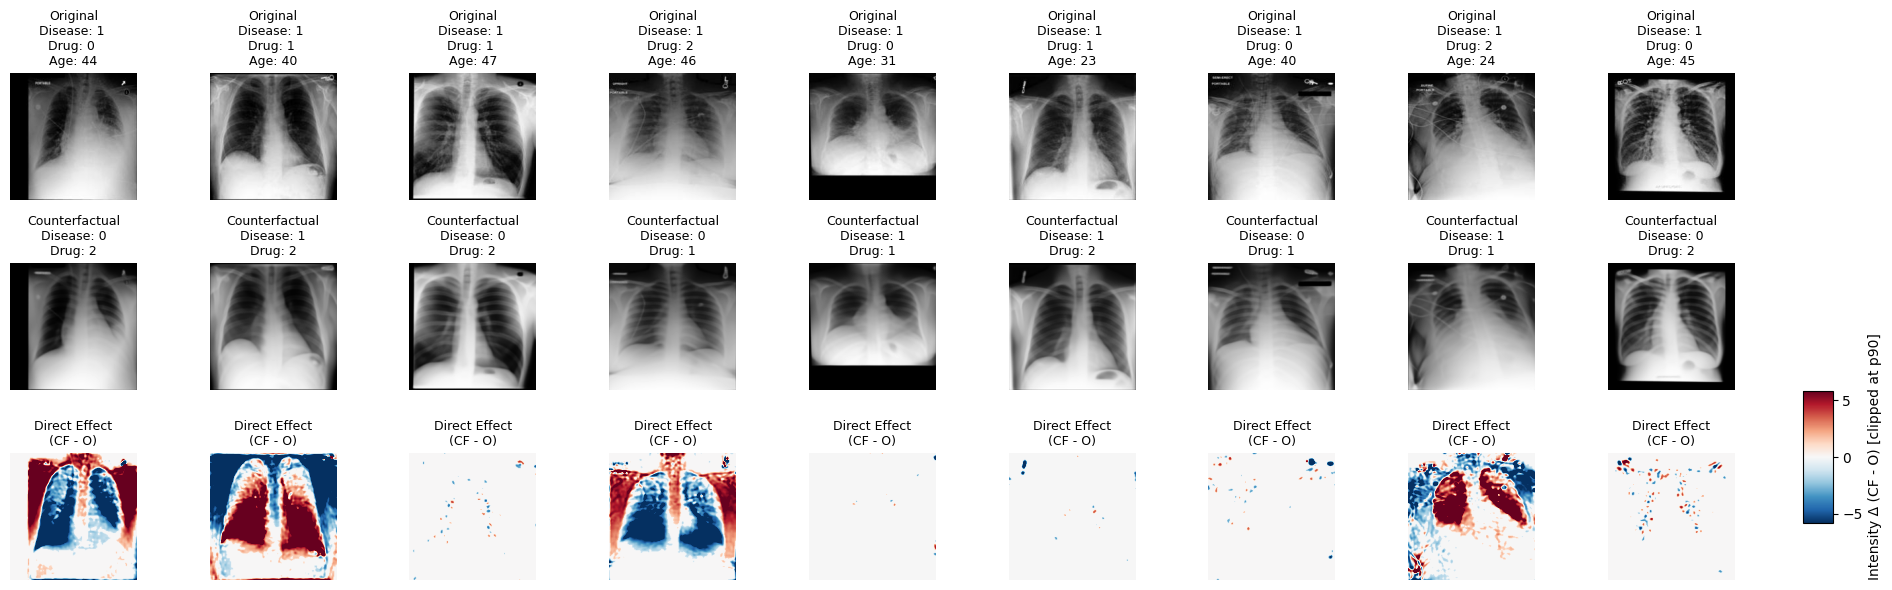

In [6]:
def test_cf_disease_visualization(vae, pgm, predictor, dataloaders, num_samples=9, te_cf: bool = False):
    """
    Generate and visualize counterfactuals on MIMIC by intervening on disease_label (finding).

    Selection:
      - Select samples randomly from available data.
    Intervention:
      - Original disease label is randomly 0 or 1 for each sample.
      - Counterfactual disease label is 1 - original_disease (flips: 0->1, 1->0)

    Visualization:
      - Use TRUE original and counterfactual parent labels (finding) from SCM / counterfactual generation.
      - Disease (finding) comes from original_pa and cf_pa (PGM outputs), not predictor image-based outputs.
    """
    vae.eval(); pgm.eval(); predictor.eval()

    assert num_samples >= 1, "num_samples should be >= 1"

    # ----------------- Prepare batch -----------------
    full_batch = next(iter(dataloaders['test']))
    # Move entire batch to GPU (temporarily) to filter
    tmp = {k: v.clone() for k,v in full_batch.items()}
    tmp = preprocess(tmp)  # now on CUDA

    # Select num_samples randomly from available batch
    batch_size = tmp['x'].shape[0]
    num_available = min(num_samples, batch_size)
    if num_available == 0:
        raise ValueError("No samples found in the batch")
    # Randomly select indices
    sel_idx = torch.randperm(batch_size)[:num_available]

    batch = {k: full_batch[k][sel_idx.cpu()] for k in full_batch.keys()}
    batch = preprocess(batch)  # final selected minibatch to CUDA

    device = batch['x'].device
    parents_order = getattr(vae, 'args', getattr(pgm, 'args', None))
    parents_order = getattr(parents_order, 'parents_x', ['finding','age','sex','race'])  # fallback

    original_x = batch['x']
    original_pa = {k: v for k, v in batch.items() if k != 'x'}
    
    # Set original disease label randomly (0 or 1) for each sample
    original_pa['finding'] = torch.randint(0, 2, (num_available, 1), device=device, dtype=torch.float32)

    # ----------------- Build intervention (flip disease label) -----------------
    if 'finding' not in original_pa:
        raise KeyError("'finding' not found in batch parents for MIMIC dataset.")
    
    finding = original_pa['finding']  # (B, 1) binary label
    # Counterfactual disease label: 40% chance to stay the same, 60% chance to flip
    flip_mask = (torch.rand(num_available, 1, device=device) > 0.3).float()
    finding_cf = finding * (1 - flip_mask) + (1 - finding) * flip_mask
    do = {'finding': finding_cf}
    do = {k: v.clone() for k, v in do.items()}  # ensure shape
    do = preprocess(do)  # ensure shape/device

    # ----------------- Generate counterfactual parents via SCM -----------------
    cf_pa = pgm.counterfactual(obs=original_pa, intervention=do, num_particles=1)

    # Ensure cf_pa contains flipped finding (overwrite if SCM kept same due to design)
    cf_pa['finding'] = finding_cf

    # ----------------- Prepare VAE parent tensors -----------------
    _pa_dict = {k: original_pa[k].clone() for k in original_pa}
    _cf_pa_dict = {k: cf_pa[k].clone() for k in cf_pa}
    input_res = getattr(getattr(vae, 'args', None), 'input_res', 192)
    _pa = vae_preprocess(_pa_dict, parents_order=parents_order, input_res=input_res, device=device)
    _cf_pa = vae_preprocess(_cf_pa_dict, parents_order=parents_order, input_res=input_res, device=device)

    # Sanity checks
    assert _pa.shape[0] == original_x.shape[0] == _cf_pa.shape[0], "Batch size mismatch in parent conditioning tensors"

    # ----------------- Latent abduction -----------------
    t_z = t_u = 0.1  # sampling temps
    z = vae.abduct(original_x, parents=_pa, t=t_z)
    if hasattr(vae, 'cond_prior') and vae.cond_prior:
        # For (H)VAE with conditional prior, z is list of dicts -> extract latent tensors
        z = [z[i]['z'] for i in range(len(z))]

    rec_loc, rec_scale = vae.forward_latents(z, parents=_pa)
    u = (original_x - rec_loc) / rec_scale.clamp(min=1e-12)

    if hasattr(vae, 'cond_prior') and vae.cond_prior and te_cf:
        cf_z = vae.abduct(x=original_x, parents=_pa, cf_parents=_cf_pa, alpha=0.65)
        cf_loc, cf_scale = vae.forward_latents(cf_z, parents=_cf_pa)
    else:
        cf_loc, cf_scale = vae.forward_latents(z, parents=_cf_pa)
    cf_scale = cf_scale * t_u
    cf_x = torch.clamp(cf_loc + cf_scale * u, min=-1, max=1)

    # Displays
    orig_display = ((original_x + 1) * 127.5).cpu()
    cf_display = ((cf_x + 1) * 127.5).cpu()

    visualize_counterfactuals(orig_display, cf_display, original_pa, cf_pa, num_samples)

    return orig_display, cf_display, original_pa, cf_pa


dataloaders = setup_dataloaders(pgm_args)
_ = test_cf_disease_visualization(vae, pgm, predictor, dataloaders, num_samples=9, te_cf=True)